# Forcasting time series values without machine learning

Salut tout le monde comme ca va!? moi super! Donc aujordhui we will look at predicting the future values of a time series using statisitcal methods rather than machine learning. We will do out best without ML, and then in a future notebook we will see how to do it with ML and compare the results.

I am following [this colab](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c03_moving_average.ipynb)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [48]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    # np.where(condition, if cond is true return this, if cond is false return this)
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Everything is np array. Type of series <class 'numpy.ndarray'>, type of noise <class 'numpy.ndarray'>


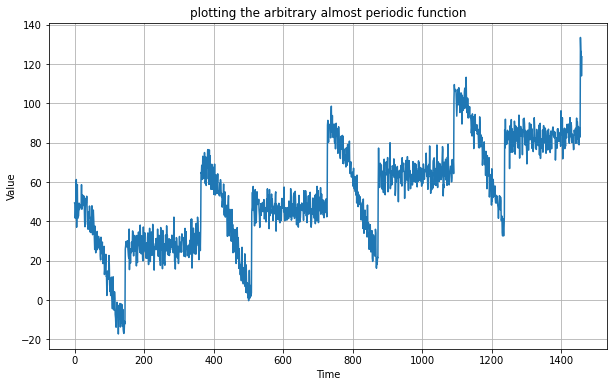

In [49]:
time = np.arange(4*365 + 1)

slope = 0.05
baseline = 10
amplitude = 40 
series = baseline + trend(time, slope) + seasonality(time, 364,amplitude)
noise_level = 5
noise = white_noise(time, noise_level, 57)
# a neat thing with np arrays is that you can add them
print("Everything is np array. Type of series {}, type of noise {}".format(type (series), type(noise)))
series += noise
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.title("plotting the arbitrary almost periodic function")
plt.show()


Now we do **Naive Forcasting** which is saying that each value at t is the same as the value of t-1 , or in otherwords the value today is the same value as yesterday. Same as saying the value tomorrow is the same as the value today

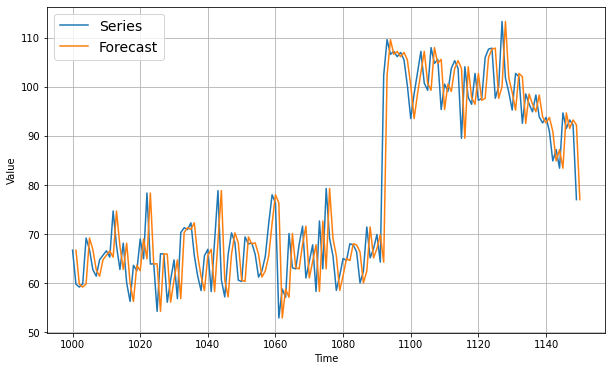

In [50]:
# we take a portion starting at 1000
split_time = 1000

time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")


In [51]:
# to know how good our forcast or future estimate is we use mae as metric
# we can use any other metric but in this mae works fine

# we can find mae in two ways,using keras is more convieniant 

x_valid = series[split_time:]
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print("THis error will be our baseline for comparison")
print(mae)

keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

THis error will be our baseline for comparison
5.731239307649875


5.731239307649876

__Moving Average__ is when the value tomorrow is equal to the average of previous values within a certain window

In [52]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

#### This above function works and all, but a faster way is to
### use np.cumsum which returns an array where every elem is the sume of all elems before it
### a= np.cumsum(np.array([1,1,1]), axis=0)
### a ---> [1,2,3]

def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

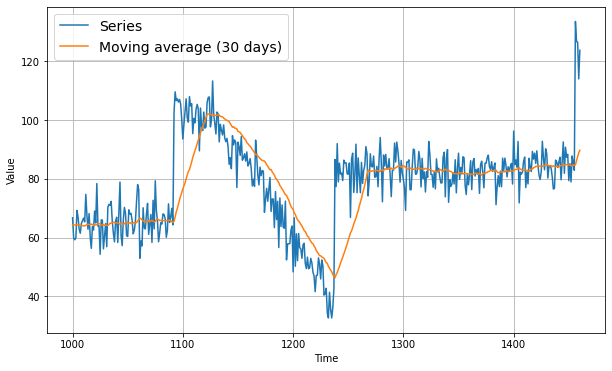

In [53]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [54]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.4637256807935595

That's worse than naive forecast! The moving average does not anticipate trend or seasonality,
 so let's try to remove them by using differencing. Since the seasonality period is 365 days,
  we will subtract the value at time t – 365 from the value at time t.

Differencing helps us get rid of trend and seasonality by subtracting the value of now (t) by the value of t-period

Watch this for more info [Link](https://youtu.be/vEozDGPwQ7c?t=156)

the difference series


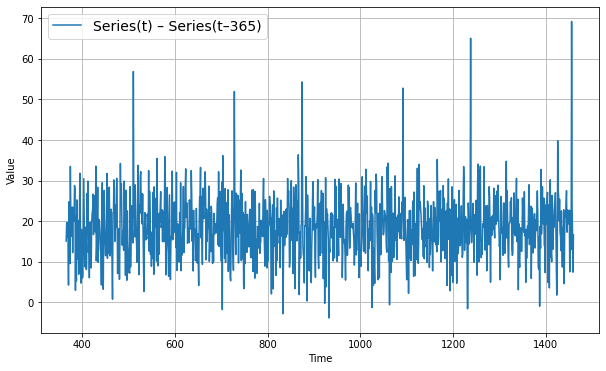

the difference series for the validation perid


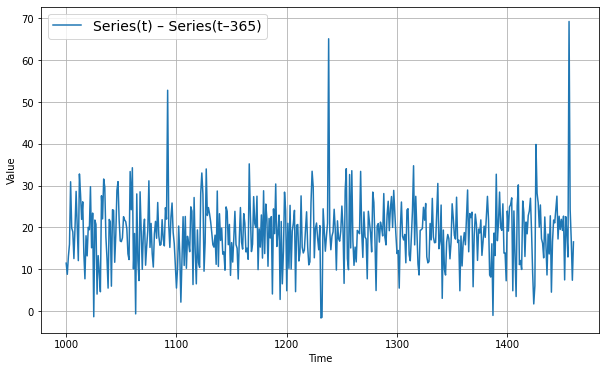

the moving avg


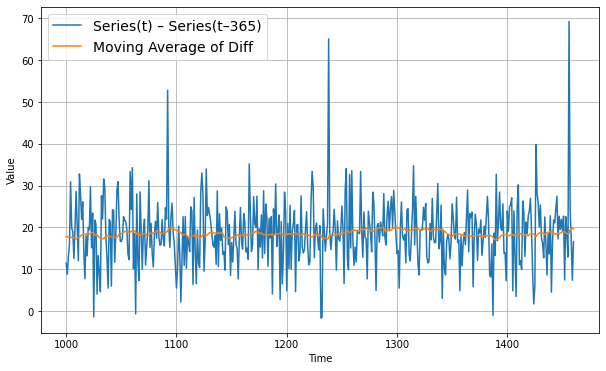

In [58]:
# the difference series
print("the difference series")
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

# the validation period
print("the difference series for the validation perid")
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

# great now with trend and seasonality gone we can use moving average
print("the moving avg")
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now we bring back trend and seasonality


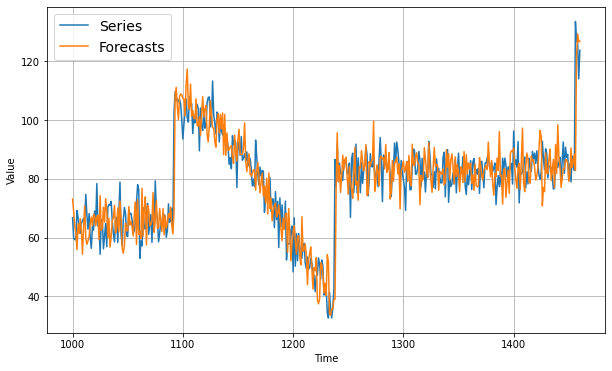

In [59]:
print("Now we bring back trend and seasonality")
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [60]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.847094110193699

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

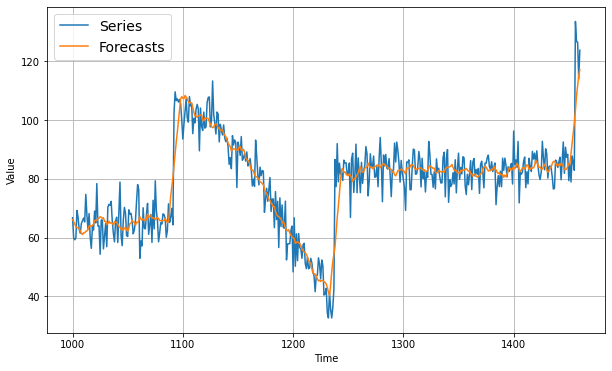

In [61]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [62]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.629122187025577

Yay this is the best result so far, let's see how we do it with ML